In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys
sys.path.insert(0,"../src")

In [16]:
import pandas as pd
import numpy as np

from fastai2 import *
from fastai2.text.all import *
import vectorize
import helpers
import transformers
from utils import *
from loss.loss import *

# Load the data

In [17]:
full_df = pd.read_pickle("../data/full_df.pkl")

In [18]:
MAX_VOCAB = None
MAX_SEQ_LENGTH = 5000
full_df['TEXT_PROCESSED'] = vectorize.clean_notes(full_df, 'TEXT')

In [19]:
full_df['ICD9_GRP_LIST'] = full_df.ICD9_GRP.apply(lambda x: re.split(" +", x.strip()))

In [20]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//475 >0:
    n = len(text1.split())//475
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:512]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*475:w*475 + 450]
      l_total.append(" ".join(l_parcial))
  return l_total

In [21]:
full_df['TEXT_PROCESSED_SPLIT'] = full_df['TEXT_PROCESSED'].apply(get_split)
full_df.head()

,TEXT,ICD9_GRP,TEXT_PROCESSED,ICD9_GRP_LIST,TEXT_PROCESSED_SPLIT
HADM_ID,,,,,
100001,"{Admission Date: [**2117-9-11**] Discharge Date: [**2117-9-17**]\n\nDate of Birth: [**2082-3-21**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nLevaquin\n\nAttending:[**First Name3 (LF) 2195**]\nChief Complaint:\nnausea, vomiting\n\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\n35F w/ poorly controlled Type 1 diabetes mellitus w/ neuropathy,\nnephropathy, HTN, gastroparesis, CKD and retinopathy, recently\nhospitalized for orthostatic hypotension [**2-3**] autonomic\nneuropathy [**Date range (1) 25088**]; DKA hospitalizations in [...",240-279 320-389 580-629 520-579 240-279 520-579 390-459 240-279 390-459 580-629 240-279 320-389 240-279 680-709,admission date discharge date date of birth sex f service medicine allergies levaquin attending chief complaint nausea vomiting major surgical or invasive procedure none history of present illness DGf w poorly controlled type DG diabetes mellitus w neuropathy nephropathy htn gastroparesis ckd and retinopathy recently hospitalized for orthostatic hypotension autonomic neuropathy dka hospitalizations in and now returning w DGd history of worsening nausea vomiting with coffee ground emesis chills and dyspnea on exertion last week she had a fall and hit her right face she also had DG day of di...,"[240-279, 320-389, 580-629, 520-579, 240-279, 520-579, 390-459, 240-279, 390-459, 580-629, 240-279, 320-389, 240-279, 680-709]",[admission date discharge date date of birth sex f service medicine allergies levaquin attending chief complaint nausea vomiting major surgical or invasive procedure none history of present illness DGf w poorly controlled type DG diabetes mellitus w neuropathy nephropathy htn gastroparesis ckd and retinopathy recently hospitalized for orthostatic hypotension autonomic neuropathy dka hospitalizations in and now returning w DGd history of worsening nausea vomiting with coffee ground emesis chills and dyspnea on exertion last week she had a fall and hit her right face she also had DG day of d...
100003,"{Admission Date: [**2150-4-17**] Discharge Date: [**2150-4-21**]\n\nDate of Birth: [**2090-5-19**] Sex: M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 12174**]\nChief Complaint:\ncoffee ground emesis\n\nMajor Surgical or Invasive Procedure:\nEGD\nRight IJ CVL\n\n\nHistory of Present Illness:\nMr. [**Known lastname 52368**] is a 59M w HepC cirrhosis c/b grade I/II esophageal\nvarices and portal gastropathy (last EGD [**3-/2150**]), who p/w\ncoffee-ground emesis and melena x2 days.\n...",520-579 290-319 001-139 520-579 390-459 520-579 390-459 520-579 780-789,admission date discharge date date of birth sex m service medicine allergies patient recorded as having no known allergies to drugs attending chief complaint coffee ground emesis major surgical or invasive procedure egd right ij cvl history of present illness mr is a DGm w hepc cirrhosis c b grade i ii esophageal varices and portal gastropathy last egd who p w coffee ground emesis and melena xDG days pt was in his usoh until about DG DG days pta when he began experiencing intermittent nausea he had DG DG episodes of coffee ground emesis and DG episode of tarry black stool in the morning of...,"[520-579, 290-319, 001-139, 520-579, 390-459, 520-579, 390-459, 520-579, 780-789]",[admission date discharge date date of birth sex m service medicine allergies patient recorded as having no known allergies to drugs attending chief complaint coffee ground emesis major surgical or invasive procedure egd right ij cvl history of present illness mr is a DGm w hepc cirrhosis c b grade i ii esophageal varices and portal gastropathy last egd who p w coffee ground emesis and melena xDG days pt was in his usoh until about DG DG days pta when he began experiencing intermittent nausea he had DG DG episodes of coffee ground emesis and DG episode of tarry b

In [22]:
def fix_max_splits(x, max_split=3):
    lsplit = len(x)
    res = []
    for i in range(0,min(lsplit, max_split)):
        if len(x[i]) == 0:
            res.append(["[PAD]"])
        else:
            res.append(x[i])
    for i in range(i+1, max_split):
        res.append(["[PAD]"])
    #print(len(res))
    return res

In [23]:
full_df['TEXT_PROCESSED_MAX_SPLIT'] = full_df.apply(lambda x: fix_max_splits(x['TEXT_PROCESSED_SPLIT']),1)

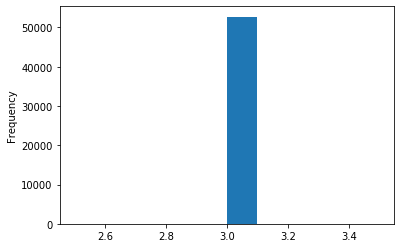

In [24]:
full_df.TEXT_PROCESSED_MAX_SPLIT.apply(lambda x: len(x)).plot.hist()

# Training

Create Item Transformations

In [25]:
from transformers import *

MODEL_CLASS = [
    [AlbertConfig, AlbertModel, 'albert-base-v2', AlbertTokenizer],
    [BertConfig, BertModel, 'bert-base-uncased', BertTokenizer]
]

idx=0

In [26]:

bert_tok = MODEL_CLASS[idx][3].from_pretrained(MODEL_CLASS[idx][2])

fastai_bert_vocab = bert_tok.vocab_size

In [27]:
sample_df = full_df.sample(frac=0.1,random_state=123)

In [28]:
item_tfms= [[ColReader('TEXT_PROCESSED_MAX_SPLIT'), FastAIBertTokenizer2(tokenizer=bert_tok,max_seq_len=512,fill_to_max=True)],
            [ColReader('ICD9_GRP_LIST') , MultiCategorize, OneHotEncode]
           ]

# Create datasource & dataloaders 

splits = RandomSplitter()(range_of(sample_df))
dsrc = Datasets(sample_df, tfms=item_tfms, splits=splits)
dls = dsrc.dataloaders(bs=4)

In [29]:
dsrc.tfms[1].vocab

(#17) ['001-139','140-239','240-279','290-319','320-389','390-459','460-519','520-579','580-629','630-679'...]

In [30]:
b = dls.one_batch()

Showing batch

In [31]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    
    # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
    
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples})
    display_df(df)

    return ctxs

In [32]:
@typedispatch
def show_results(x, y, samples, outs, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
        
        # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    result_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
        result_samples.append(outs[i][0])
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples,'Result': result_samples})
    display_df(df)
    
    return ctxs

In [33]:
dls.show_batch(b)

,Text,Label
0,ng fatigue and weakness associated with weight gain over the last several days patient is very somnlent on interview but he is able to relate that he has generally felt unwell for the past several mon,"[240-279, 290-319, 320-389, 390-459, 460-519, 580-629, 780-789]"
1,ocarcinoma to the liver and peritoneum status post multiple failed chemotherapeutic regimens as well as disease progression despite palliative chemo and xrt who initially presented yesterday with abdo,"[001-139, 140-239, 240-279, 390-459, 520-579, 780-789, 800-999]"
2,ld right handed woman with a large posterior scalp mass but no other significant medical history who was brought to an osh after having been found down and head ct was concerning for a right parietal,"[001-139, 240-279, 320-389, 390-459, 460-519, 680-709, 710-739, 780-789, 790-796, 800-999]"
3,ferred from with chest and back pain she underwent a cat scan which revealed the presence of a contained rupture of a descending thoracic aneurysm based on these findings the patient was consented for,"[240-279, 390-459]"


# Modelling

In [34]:
from models.lstm_attn import *
from models.lstm import *
from models.bert_clinical import *
from loss.loss import *
from fastai2.metrics import *
from transformers import BertModel, BertConfig
from utils import *

In [36]:
dsrc.tfms[1].vocab

(#17) ['001-139','140-239','240-279','290-319','320-389','390-459','460-519','520-579','580-629','630-679'...]

In [38]:
V = fastai_bert_vocab
E = 50
C = len(dsrc.tfms[1].vocab)

In [ ]:
#load_wordvectors(glove_path)
glove_path = "../data"
weights_matrix = get_glove_matrix(glove_path, fastai_bert_vocab, emb_dim=E)

In [39]:
# Loss function
loss_func = ICD_Loss(ignore_index=0)

# Metrics
acc_02 = partial(accuracy_multi, thresh=0.5)
f_score = F1ScoreMulti(thresh=0.2)

# Configuration
config = MODEL_CLASS[idx][0].from_pretrained(MODEL_CLASS[idx][2]) 

# bert Model from configuration
bert = MODEL_CLASS[idx][1](config)

# Model
model = BertClinical(bert, config=config, num_labels=C)
#model = BiLSTMWithBertEmbedding(config,V=V, E=E, C=C)
#model = SelfAttentionLSTM(V=V, E=E, C=C, weights_matrix=weights_matrix)
model.freeze_bert_encoder()

In [40]:
learn = Learner(dls, model, loss_func = loss_func, metrics=[acc_02, f_score])

In [ ]:
del dls, learn
torch.cuda.empty_cache()

(0.0019054606556892395, 0.002511886414140463)

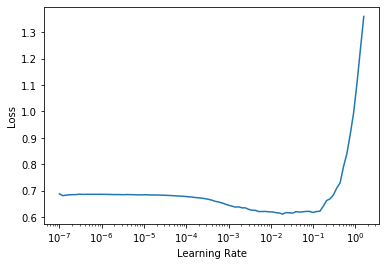

In [41]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=10e-3)
learn.save('bert_1epoch')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time


In [ ]:
learn.save('3epoch')

In [ ]:
learn.load('3epoch')

In [ ]:
learn.fit_one_cycle(10, lr_max=10e-6)
learn.save('10epoch')

# Show results

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results()

In [ ]:
preds,targs = learn.get_preds()


In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)


In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
[[k,v] for k,v in zip(xs, accs)]

SelfAttentionWithLSTM

3 epoch:

10 epoch:

